In [1]:
import argparse
import pandas as pd
import math
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
import sys
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

# Set font properties
plt.rcParams.update({
    'font.size': 16,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

In [2]:
path = '../tidy_data/bootstrap'
files = os.listdir(path)

In [3]:
df_l = []

for i,f in enumerate(files):
    if i % 50 == 0: print(i)
    df = pd.read_parquet(f'{path}/{f}')
    df_l.append(df)

0
50
100


: 

: 

In [11]:
res = pd.concat(df_l)

In [74]:
res['n_cases'] = res.FN + res.TP
res['n_controls'] = res.FP + res.TN

In [88]:
res.columns

Index(['n_features', 'proteins', 'outcome', 'iteration', 'bootstrap', 'TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos', 'n_cases', 'n_controls'],
      dtype='object')

In [75]:
print(set(res.n_features))
res.head()

{100, 5, 1000, 2923, 50, 500}


,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos,n_cases,n_controls
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",132016-0.0,0,0,7796,2663,25,12,0.536583,...,0.743902,0.534856,0.996803,0.004486,0.745387,0.324324,0.852954,0.008850,37,10459
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",132016-0.0,0,1,7791,2668,26,11,0.517674,...,0.743331,0.521103,0.996674,0.004106,0.744909,0.297297,0.852594,0.008100,37,10459
2,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",132016-0.0,0,2,7798,2661,26,11,0.519421,...,0.743998,0.521438,0.996677,0.004117,0.745578,0.297297,0.853033,0.008121,37,10459
3,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",132016-0.0,0,3,7793,2666,26,12,0.525707,...,0.743546,0.530445,0.996675,0.004481,0.745100,0.315789,0.852719,0.008837,38,10459
4,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",132016-0.0,0,4,7797,2662,26,12,0.525775,...,0.743927,0.530636,0.996676,0.004488,0.745482,0.315789,0.852970,0.008850,38,10459


In [89]:
group_median = res.groupby(['n_features', 'outcome'])[['TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos', 'n_cases', 'n_controls']].median()

In [90]:
group_median

TN     FP     FN    TP     auroc  avg_prec  \
n_features outcome                                                       
5          130194-0.0   9880.0  589.0   26.0   2.0  0.545913  0.003415   
           130216-0.0   9703.0  519.0  232.0  43.0  0.608526  0.045069   
           130660-0.0   9462.0  858.0  154.0  24.0  0.554266  0.021377   
           130664-0.0  10159.0  293.0   42.0   2.0  0.529654  0.005310   
           130670-0.0  10159.0  266.5   67.0   4.0  0.569708  0.009410   
...                        ...    ...    ...   ...       ...       ...   
2923       132248-0.0  10470.0   13.0   14.0   0.0  0.570887  0.009619   
           132250-0.0  10122.0  328.0   23.0  25.0  0.919833  0.060833   
           132276-0.0   9513.0  658.0  250.0  77.0  0.796236  0.096214   
           132468-0.0  10367.0   92.0   36.0   2.0  0.601539  0.008452   
           132472-0.0  10058.0  421.0   17.0   1.0  0.477443  0.002031   

                       best_thresh   best_f1  accuracy  balanced_acc  \
n_features outcome                                                     
5          130194-0.0     0.564776  0.011268  0.941602      0.513538   
           130216-0.0     0.677202  0.103535  0.928360      0.552698   
           130660-0.0     0.573335  0.045369  0.903830      0.524401   
           130664-0.0     0.616264  0.017003  0.968086      0.509068   
           130670-0.0     0.623195  0.028070  0.968181      0.516508   
...                            ...       ...       ...           ...   
2923       132248-0.0     0.649097  0.071429  0.997428      0.499380   
           132250-0.0     0.369002  0.129353  0.966562      0.744721   
           132276-0.0     0.640414  0.145764  0.913499      0.585412   
           132468-0.0     0.511149  0.045113  0.987806      0.521918   
           132472-0.0     0.309489  0.009070  0.958274      0.507690   

                       prec_neg  prec_pos   rec_neg   rec_pos    f1_neg  \
n_features outcome                                                        
5          130194-0.0  0.997344  0.003164  0.943739  0.071429  0.969911   
           130216-0.0  0.976637  0.075684  0.949227  0.156364  0.962691   
           130660-0.0  0.984000  0.026270  0.916860  0.134831  0.949362   
           130664-0.0  0.995861  0.005215  0.971967  0.045455  0.983780   
           130670-0.0  0.993453  0.014060  0.974438  0.056338  0.983827   
...                         ...       ...       ...       ...       ...   
2923       132248-0.0  0.998665  0.000000  0.998760  0.000000  0.998712   
           132250-0.0  0.997733  0.070621  0.968612  0.520833  0.982957   
           132276-0.0  0.974393  0.104294  0.935306  0.235474  0.954450   
           132468-0.0  0.996540  0.021277  0.991204  0.052632  0.993864   
           132472-0.0  0.998313  0.002370  0.959824  0.055556  0.978690   

                         f1_pos  n_cases  n_controls  
n_features outcome                                    
5          130194-0.0  0.006283     29.0     10468.0  
           130216-0.0  0.100595    275.0     10222.0  
           130660-0.0  0.043296    177.0     10320.0  
           130664-0.0  0.009867     45.0     10452.0  
           130670-0.0  0.021661     71.0     10426.0  
...                         ...      ...         ...  
2923       132248-0.0  0.000000     14.0     10483.0  
           132250-0.0  0.124688     48.0     10449.0  
           132276-0.0  0.144280    327.0     10170.0  
           132468-0.0  0.030303     38.0     10459.0  
           132472-0.0  0.004545     18.0     10479.0  

[402 rows x 18 columns]

Text(0.5, 0, 'Precision')

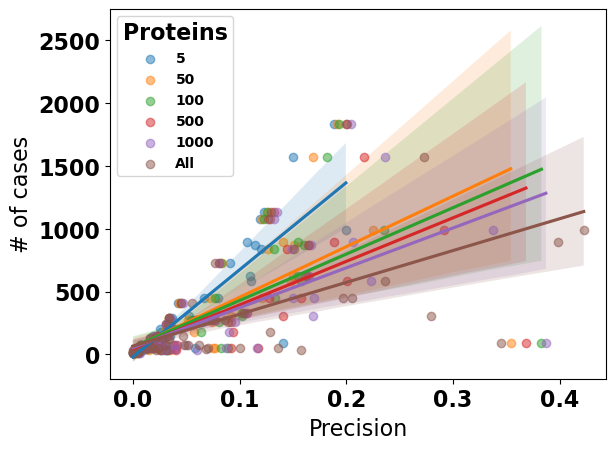

In [95]:
xlabel_dict = {'auroc': 'AUROC', 'prec_pos': 'Precision'}

x_col = 'prec_pos'
y_col = 'n_cases'
sns.regplot(data=group_median.loc[(5)], x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, label='5' )
sns.regplot(data=group_median.loc[(50)], x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, label='50')
sns.regplot(data=group_median.loc[(100)], x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, label='100')
sns.regplot(data=group_median.loc[(500)], x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, label='500')
sns.regplot(data=group_median.loc[(1000)], x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, label='1000')
sns.regplot(data=group_median.loc[(2923)], x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, label='All')
plt.legend(title="Proteins", fontsize=10)
plt.ylabel("# of cases")
plt.xlabel(xlabel_dict[x_col])

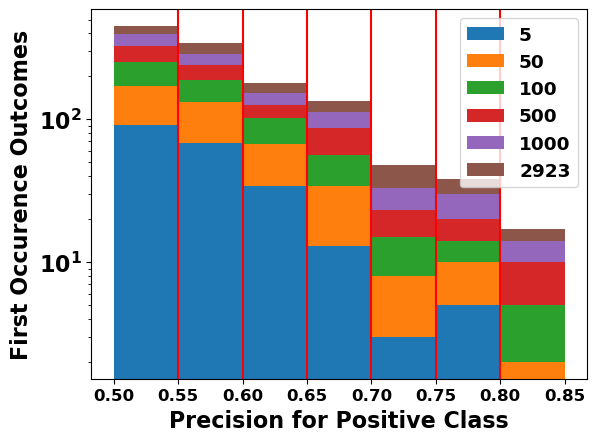

In [106]:
marker_range = np.arange(0.5,0.9,0.05)
metric = 'AUROC'
newcols = []
for nf in [5, 50, 100, 500, 1000, 2923]:
 newcols.append(dfres[dfres.n_features == nf][metric])

df_newcols = pd.concat(newcols, axis=1)
df_newcols.columns = [str(x) for x in [5, 50, 100, 500, 1000, 2923]]

plt.hist(df_newcols, bins = marker_range, 
    histtype='bar', stacked=True, label = [5, 50, 100, 500, 1000, 2923], log=True)
plt.legend(fontsize='small')
plt.ylabel("First Occurence Outcomes", weight='bold')
plt.xlabel("Precision for Positive Class", weight='bold')

# Adjust font properties for x-axis tick labels
plt.tick_params(axis='x', labelsize=12)  # Set font size for x-axis tick labels

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=900, color='red')

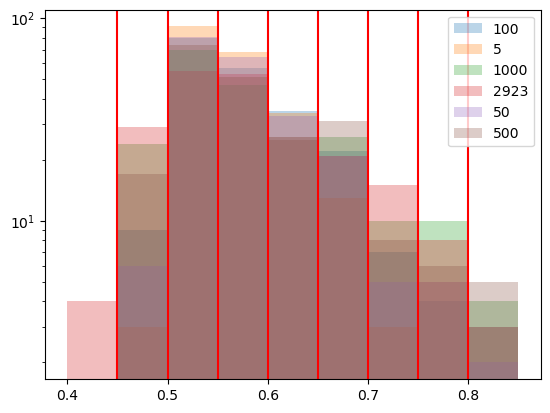

In [59]:
for nf in [5, 50, 100, 500, 1000, 2923]:
    plt.hist(dfres[dfres.n_features == nf].AUROC, bins=marker_range, log=True, alpha=0.3, label=nf)
    plt.legend()

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=500, color='red')
    # plt.vlines(0.6, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.7, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.8, ymin=0.5, ymax=500, color='k')